# <div align="center">State Farm Distracted Driver Detection</div>

In [1]:
import tensorflow as tf
print("GPU Available:", tf.test.is_gpu_available())

2024-04-08 18:43:47.726608: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 18:43:47.726714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 18:43:47.978785: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU Available: True


In [2]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet50

In [3]:
# Load data
train_dir = '/kaggle/input/state-farm-distracted-driver-detection/imgs/train'

In [4]:
# Data augmentation and preprocessing
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator( rescale=1./255, validation_split=0.2)

In [5]:
# Data generators for training and validation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    subset='training'  
)


Found 17943 images belonging to 10 classes.


In [6]:
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    subset='validation'  
)

Found 4481 images belonging to 10 classes.


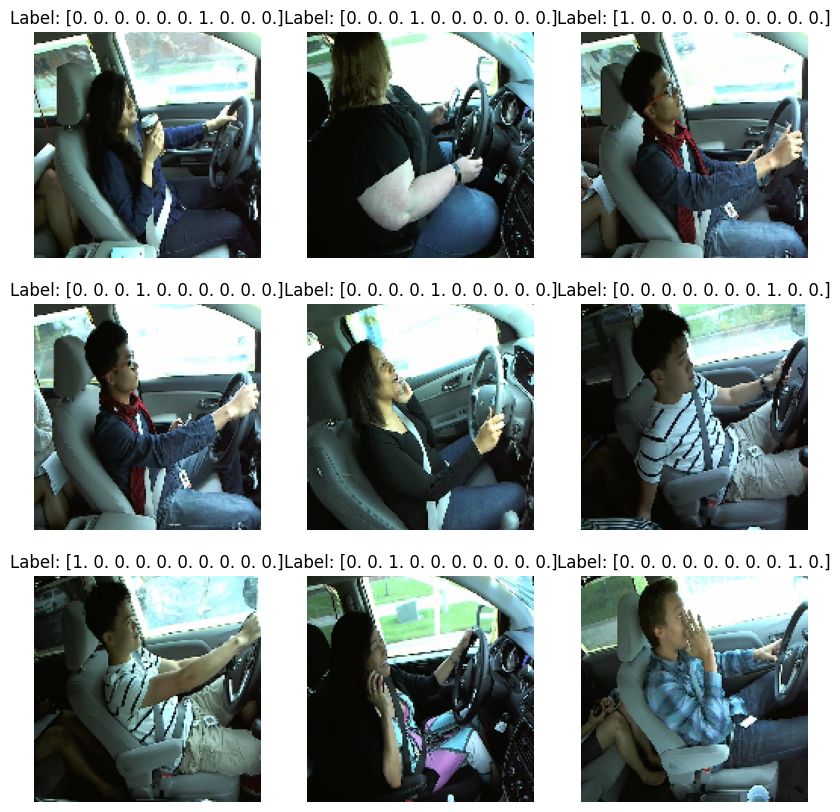

In [7]:
# Visualize sample data
def visualize_sample_data(generator: tf.keras.preprocessing.image.DirectoryIterator) -> None:
    """Visualize sample data from the generator."""
    images, labels = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.show()

visualize_sample_data(train_generator)

In [8]:
# Train and evaluate models
def train_and_evaluate_model(model: tf.keras.Model, train_generator: tf.keras.preprocessing.image.DirectoryIterator,
                             validation_generator: tf.keras.preprocessing.image.DirectoryIterator, epochs: int = 50,
                             batch_size: int = 64) -> None:
    """
    Train and evaluate the model.

    Parameters:
        model (tf.keras.Model): The compiled model to train and evaluate.
        train_generator (tf.keras.preprocessing.image.DirectoryIterator): The training data generator.
        validation_generator (tf.keras.preprocessing.image.DirectoryIterator): The validation data generator.
        epochs (int): The number of epochs for training.
        batch_size (int): The batch size for training and evaluation.
    """
    # Compile the model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(0.0001),
        metrics=['accuracy']
    )
    
    # Train the model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        #steps_per_epoch=len(train_generator),
        steps_per_epoch= 17943 // 64,
        #steps_per_epoch=len(train_generator) // batch_size, 
        
        validation_steps=len(validation_generator),
        epochs=epochs,
        batch_size=batch_size
    )
    
    # Plot training history
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    # Generate heatmaps
    predictions = model.predict(validation_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = validation_generator.classes
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Evaluate the model on test data
    test_loss, test_acc = model.evaluate(validation_generator, verbose=2)
    print(f'Test Accuracy: {test_acc}')
    
    # Generate submission file
    test_images = [file.split('/')[-1] for file in validation_generator.filenames]
    test_predictions = model.predict(validation_generator)
    submission_filename = model.name + '_submission.txt'
    with open(submission_filename, 'w') as file:
        for img, pred in zip(test_images, test_predictions):
            file.write(img + '\n')
            for p in pred:
                file.write(str(p) + '\n')
            file.write('\n')
    print(f'Submission file {submission_filename} generated.')


In [9]:
# Function to create Dense model
def create_dense_model(input_shape: tuple = (150, 150, 3), num_classes: int = 10) -> tf.keras.Model:
    """
    Create a dense neural network model.

    Parameters:
        input_shape (tuple): The input shape of the images (height, width, channels).
        num_classes (int): The number of classes for classification.

    Returns:
        tf.keras.Model: The compiled dense neural network model.
    """
    model = tf.keras.Sequential([
        Flatten(input_shape=input_shape),
        Dense(512,activation='relu'),
        Dense(128,activation='relu'),
        Dense(64,activation='relu'),
        Dense(32,activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [10]:
# Create Dense model
dense_model = create_dense_model()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
# Display model summary
print("\nBaseline Dense Layers Model Summary:")
dense_model.summary()


Baseline Dense Layers Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    34,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,636,842 (132.13 MB)

 Trainable params: 34,636,842 (132.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/280 ━━━━━━━━━━━━━━━━━━━━ 42:51 9s/step - accuracy: 0.0625 - loss: 2.3302

I0000 00:00:1712602150.041333     102 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712602150.056754     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 93/280 ━━━━━━━━━━━━━━━━━━━━ 2:00 646ms/step - accuracy: 0.1457 - loss: 2.3608

W0000 00:00:1712602209.513728     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - accuracy: 0.2715 - loss: 2.0938

W0000 00:00:1712602315.091658     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


280/280 ━━━━━━━━━━━━━━━━━━━━ 214s 733ms/step - accuracy: 0.2721 - loss: 2.0925 - val_accuracy: 0.6882 - val_loss: 1.1606
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 89us/step - accuracy: 0.6094 - loss: 1.2695 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/50


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


280/280 ━━━━━━━━━━━━━━━━━━━━ 74s 261ms/step - accuracy: 0.7687 - loss: 0.9165 - val_accuracy: 0.9208 - val_loss: 0.4534
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 72us/step - accuracy: 0.9219 - loss: 0.4483 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 72s 253ms/step - accuracy: 0.9196 - loss: 0.4069 - val_accuracy: 0.9402 - val_loss: 0.2994
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 52us/step - accuracy: 0.9219 - loss: 0.3577 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 73s 256ms/step - accuracy: 0.9537 - loss: 0.2348 - val_accuracy: 0.9712 - val_loss: 0.1596
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 64us/step - accuracy: 1.0000 - loss: 0.1290 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 74s 260ms/step - accuracy: 0.9782 - loss: 0.1338 - val_accuracy: 0.9696 - val_loss: 0.1472
Epoch 10/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 62us/step - accuracy: 0.9844 - l

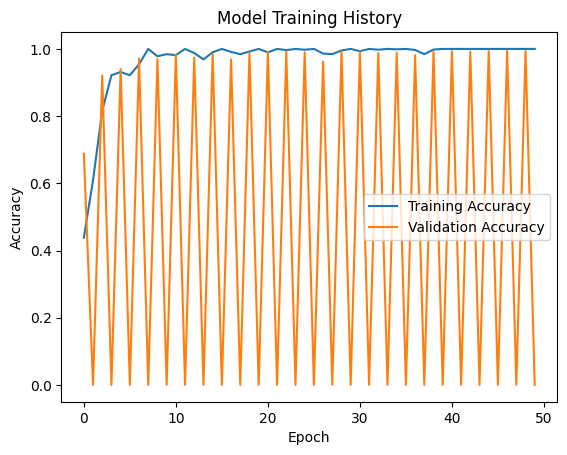

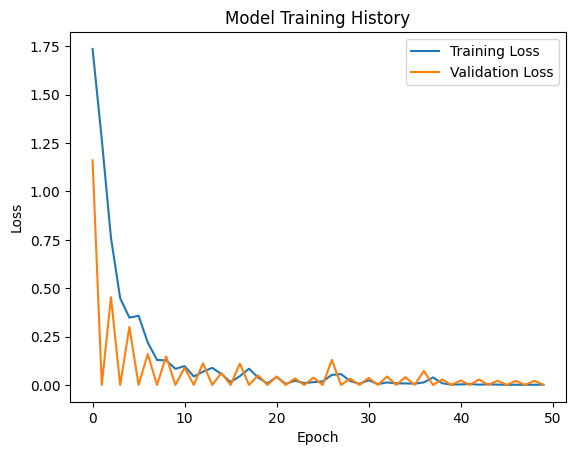

 1/71 ━━━━━━━━━━━━━━━━━━━━ 36s 525ms/step

W0000 00:00:1712604156.860156     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


71/71 ━━━━━━━━━━━━━━━━━━━━ 15s 214ms/step


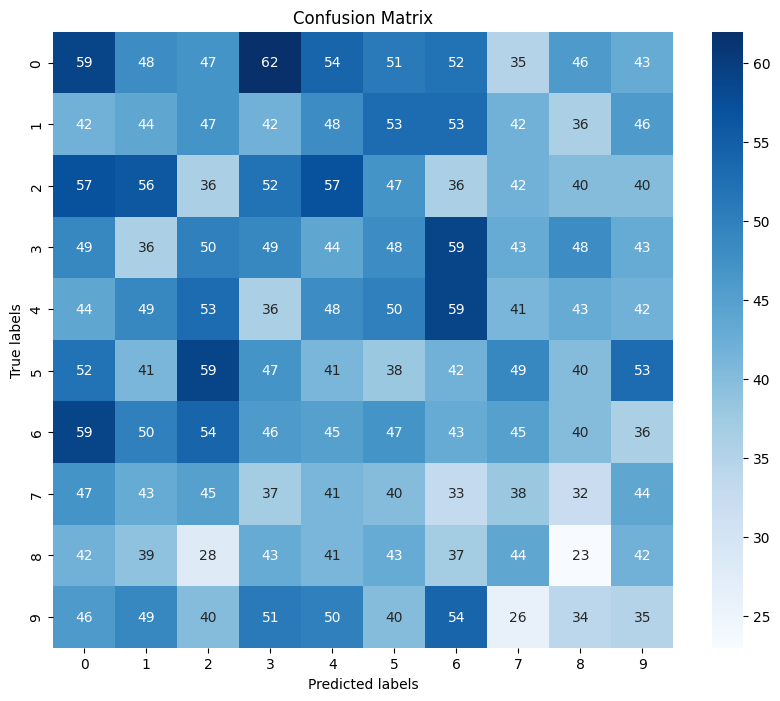

71/71 - 15s - 215ms/step - accuracy: 0.9940 - loss: 0.0214
Test Accuracy: 0.9939745664596558
71/71 ━━━━━━━━━━━━━━━━━━━━ 15s 211ms/step
Submission file sequential_submission.csv generated.


In [12]:
# Train and evaluate Dense model
train_and_evaluate_model(dense_model, train_generator, validation_generator)

In [13]:
#Function to create CNN model
def create_cnn_model(input_shape: tuple = (150, 150, 3), num_classes: int = 10) -> tf.keras.Model:
    """
    Create a convolutional neural network model.

    Parameters:
        input_shape (tuple): The input shape of the images (height, width, channels).
        num_classes (int): The number of classes for classification.

    Returns:
        tf.keras.Model: The compiled convolutional neural network model.
    """
    model = tf.keras.Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [14]:
# Create CNN model
cnn_model = create_cnn_model()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [15]:
# Display model summary
print("\nCNN Model Summary:")
cnn_model.summary()


CNN Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,642 (18.42 MB)

 Trainable params: 4,829,642 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 95s 294ms/step - accuracy: 0.2860 - loss: 1.9729 - val_accuracy: 0.8942 - val_loss: 0.5171
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 54us/step - accuracy: 0.6875 - loss: 0.9733 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/50


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


280/280 ━━━━━━━━━━━━━━━━━━━━ 76s 266ms/step - accuracy: 0.8014 - loss: 0.6094 - val_accuracy: 0.9601 - val_loss: 0.1665
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 55us/step - accuracy: 0.8438 - loss: 0.3891 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 75s 263ms/step - accuracy: 0.9070 - loss: 0.3116 - val_accuracy: 0.9752 - val_loss: 0.0893
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 53us/step - accuracy: 0.9531 - loss: 0.2329 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 78s 272ms/step - accuracy: 0.9343 - loss: 0.2146 - val_accuracy: 0.9846 - val_loss: 0.0601
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 60us/step - accuracy: 0.9688 - loss: 0.1177 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 77s 269ms/step - accuracy: 0.9507 - loss: 0.1686 - val_accuracy: 0.9871 - val_loss: 0.0458
Epoch 10/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 60us/step - accuracy: 0.9375 - l

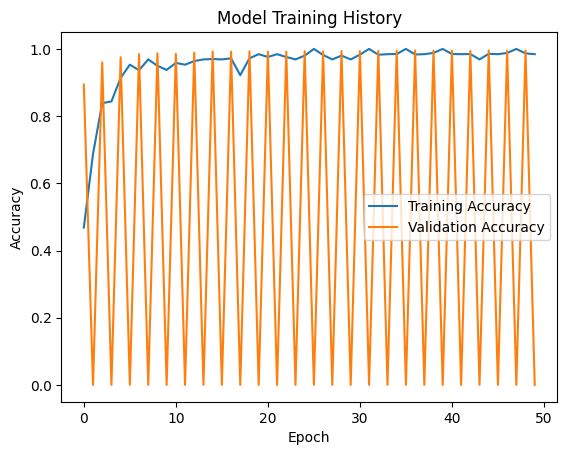

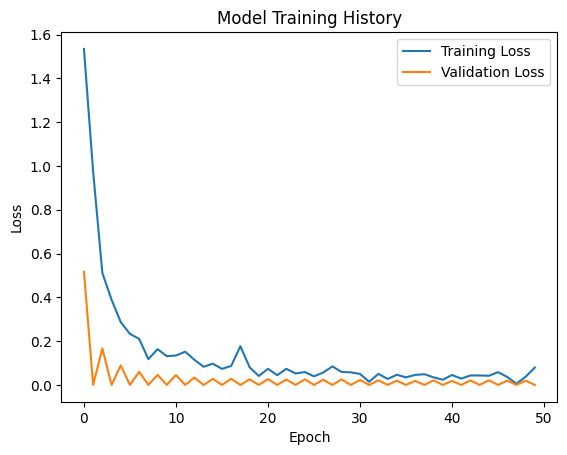

71/71 ━━━━━━━━━━━━━━━━━━━━ 15s 210ms/step


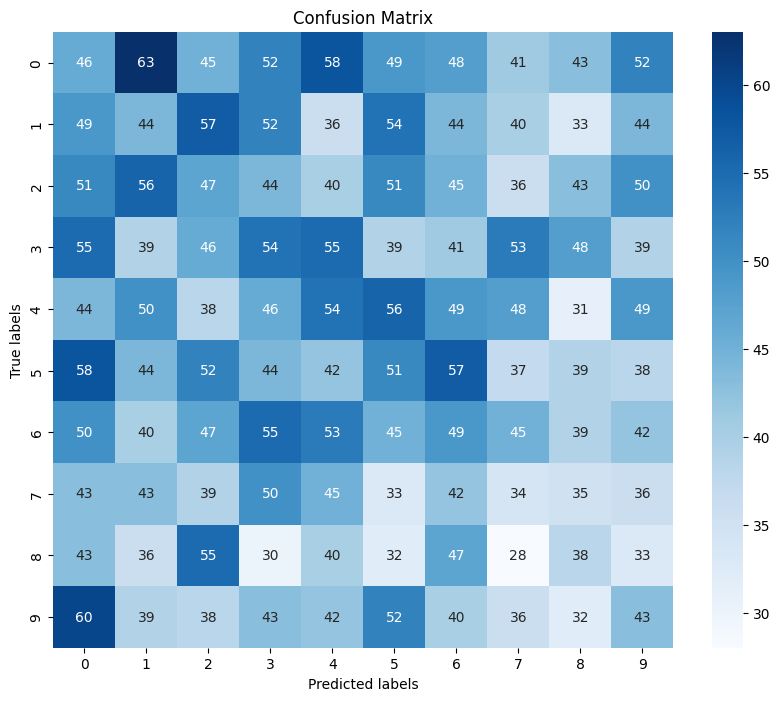

71/71 - 15s - 211ms/step - accuracy: 0.9955 - loss: 0.0197
Test Accuracy: 0.9955366849899292
71/71 ━━━━━━━━━━━━━━━━━━━━ 16s 221ms/step
Submission file sequential_1_submission.csv generated.


In [16]:
# Train and evaluate CNN model
train_and_evaluate_model(cnn_model, train_generator, validation_generator)

In [18]:
#Function to create ResNet50 model
def create_resnet_model(input_shape: tuple = (150, 150, 3), num_classes: int = 10) -> tf.keras.Model:
    """
    Create a ResNet model.

    Parameters:
        input_shape (tuple): The input shape of the images (height, width, channels).
        num_classes (int): The number of classes for classification.

    Returns:
        tf.keras.Model: The compiled ResNet model.
    """
    conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    conv_base.trainable = False
    model = tf.keras.models.Sequential([
        conv_base,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [19]:
 # Create ResNet model
resnet_model = create_resnet_model()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [20]:
# Display model summary
print("\nResNet50 Model Summary:")
resnet_model.summary()


ResNet50 Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/50
  1/280 ━━━━━━━━━━━━━━━━━━━━ 1:29:01 19s/step - accuracy: 0.0625 - loss: 2.8387

W0000 00:00:1712606335.820508     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.1150 - loss: 2.3212

W0000 00:00:1712606408.073489     102 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


280/280 ━━━━━━━━━━━━━━━━━━━━ 109s 324ms/step - accuracy: 0.1151 - loss: 2.3211 - val_accuracy: 0.2029 - val_loss: 2.2279
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 152us/step - accuracy: 0.2031 - loss: 2.2186 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/50


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


280/280 ━━━━━━━━━━━━━━━━━━━━ 76s 266ms/step - accuracy: 0.1637 - loss: 2.2194 - val_accuracy: 0.2310 - val_loss: 2.1526
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 66us/step - accuracy: 0.2344 - loss: 2.1891 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 76s 266ms/step - accuracy: 0.1774 - loss: 2.1579 - val_accuracy: 0.2607 - val_loss: 2.0781
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 76us/step - accuracy: 0.2031 - loss: 2.1222 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 76s 264ms/step - accuracy: 0.1902 - loss: 2.1001 - val_accuracy: 0.3303 - val_loss: 2.0186
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 79us/step - accuracy: 0.1719 - loss: 2.1430 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 76s 267ms/step - accuracy: 0.1939 - loss: 2.0647 - val_accuracy: 0.3156 - val_loss: 1.9492
Epoch 10/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - accuracy: 0.1875 - l

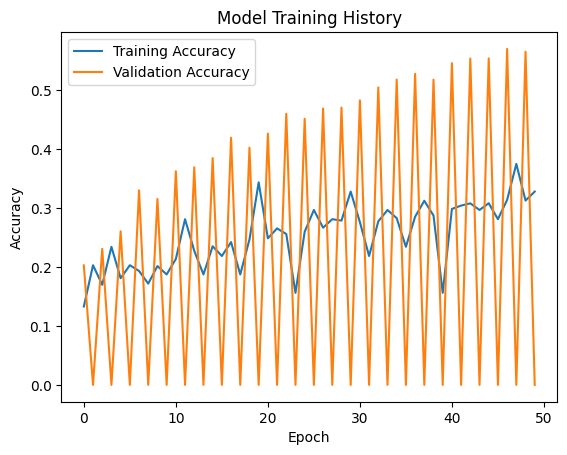

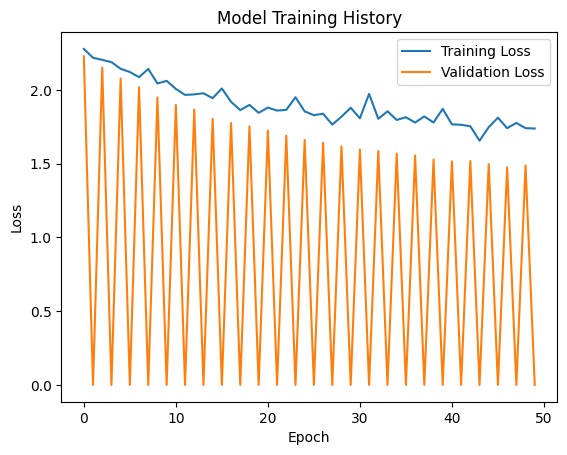

 2/71 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step

W0000 00:00:1712608268.153158     105 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


71/71 ━━━━━━━━━━━━━━━━━━━━ 22s 255ms/step


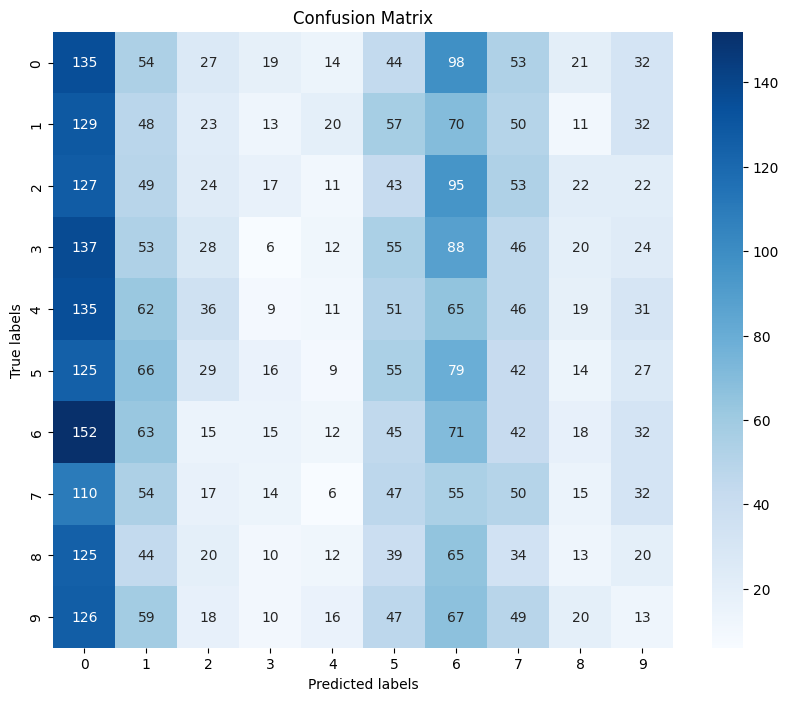

71/71 - 15s - 208ms/step - accuracy: 0.5666 - loss: 1.4869
Test Accuracy: 0.56661456823349
71/71 ━━━━━━━━━━━━━━━━━━━━ 15s 210ms/step
Submission file sequential_2_submission.csv generated.


In [21]:
# Train and evaluate ResNet model
train_and_evaluate_model(resnet_model, train_generator, validation_generator)